# Part 2: Replay
I now explore how stimulus-specific replay could emerge in this neural network via history-dependent excitability, that is, the tendency of a node to exhibit a temporarily increased activation probability following its own recent activation in the past. History-dependent excitability of a node could arise from a number of molecular mechanisms in its constituent neurons, such as slow ion channel dynamics or calcium dynamics (various other mechanisms are discussed and referenced in [Baroni et al., 2010][1]). Alternatively, it could arise via low levels of persistent electrical activity whose onset is triggered by the activation of the original node, and which sends excitatory feedback to that node. Such a hypothesis is consistent with evidence for low levels of stimulus-tuned activity in early sensory cortex that persists during the delay period of a working memory task.

Here I abstract away from a specific mechanism of history dependent excitability and instead model it as an additional input $s_{hde}$ that a node receives at all times subsequent to its original activation.

Thus, a node may receive three types of inputs:
* inputs from upstream nodes, weighted by their connectivity
* external drive
* history-dependent excitability inputs

In [1]:
%matplotlib inline
import softmax_chains_replay

### Stimulus-specific replay
Here I demonstrate that activating a specific chain in the network causes segments of that chain to replay even after the offset of the stimulus. For the first half of each trial I present sequential external drives activating a specific chain. On the second half of the trial I present no inputs, so all activity is spontaneous.

In [2]:
CONFIG = {
    'SEED': None,
    
    'N_CHAINS': 9,
    'CHAIN_LENGTH': 4,
    'GAIN': 7,
    'HDE_INPUT_VALUE': 1,
    
    'DRIVE_BY_COORDINATE': [
            [((chain_idx, chain_pos), 3) for chain_pos in range(4)]  # first half of trial
            + 4 * [((0, 0), 0)]  # second half of trial
            for chain_idx in range(6)
        ],
    
    'N_TRIALS': 6,
    
    'FIG_SIZE': (15, 8),
    'COLORS': [(0, 0, 0), (1, 0, 0), (0, 1, 0), (0, 0, 1), (0, 1, 1), (1, 0, 1), (.5, .5, 0), (.5, .5, .5), (.5, 0, 0)],
    'LW': 2,
    'FONT_SIZE': 16,
}

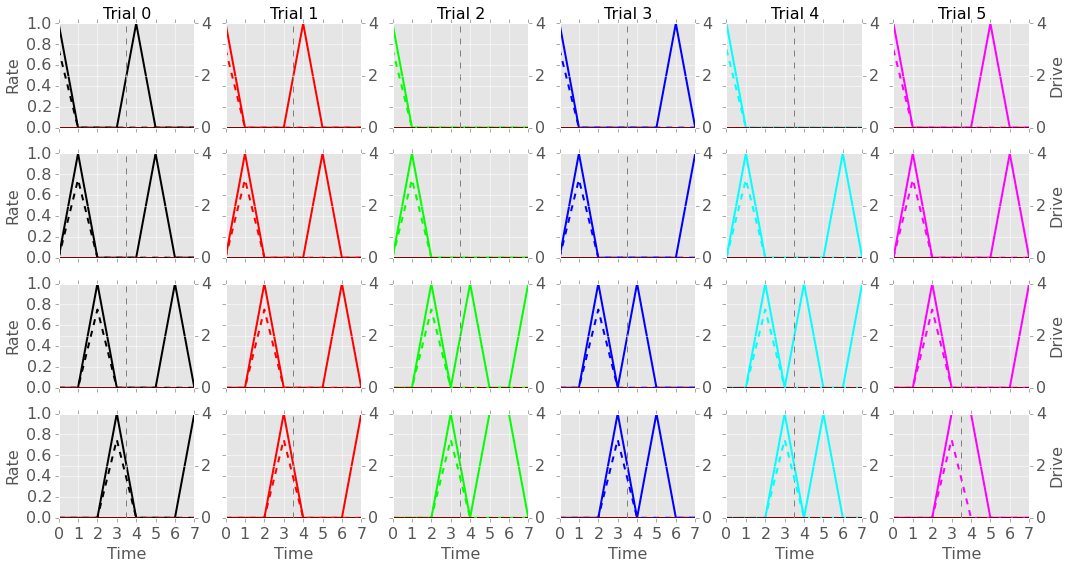

In [5]:
softmax_chains_replay.replay(CONFIG)

As expected, since activating individual nodes leaves them in a "primed" state, nodes in an activated chain are more likely to activate spontaneously.

### Replay depends on history-dependent excitability
If we set the $s_{hde} = 0$, we see that stimulus-specific replay no longer occurs.

In [3]:
CONFIG['HDE_INPUT_VALUE'] = 0

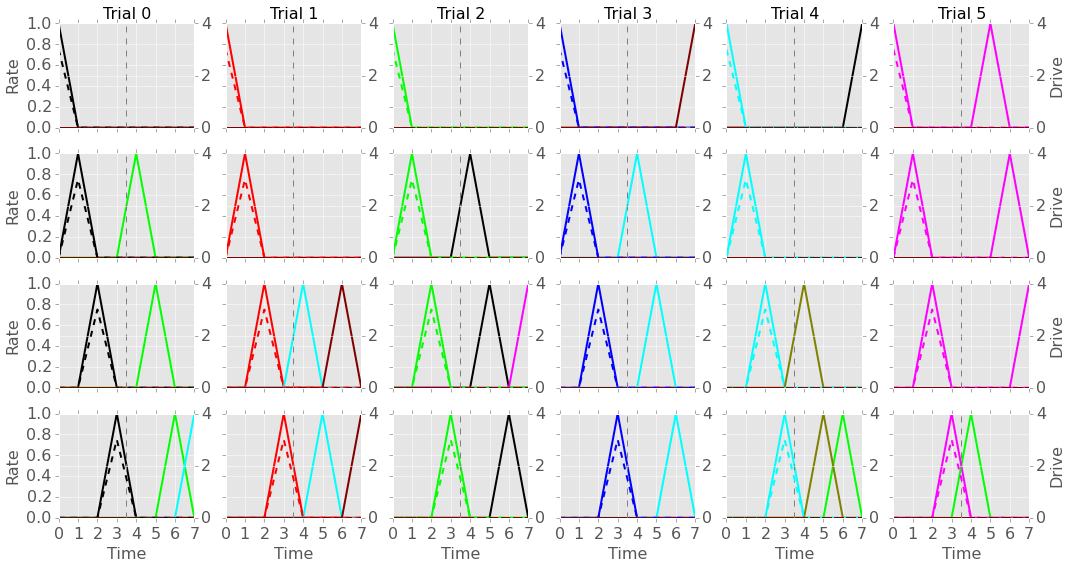

In [10]:
softmax_chains_replay.replay(CONFIG)

This is because after the external drive is finished and a chain finishes there is no preference for any node to activate after any other.

### External drive that is similar but not identical to prior activity patterns
Returning to the case of a nonzero $s_{hde}$: If the external drive activates most of one chain and a small portion of another, the subsequent spontaneously active sequences will show a preference for the more activated chain.

In [3]:
CONFIG['HDE_INPUT_VALUE'] = 1
CONFIG['DRIVE_BY_COORDINATE'] = [
    [((0, chain_pos), 3) if chain_pos != 2 else ((1, chain_pos), 3) for chain_pos in range(4)]
    + 4 * [((0, 0), 0)]
    for _ in range(6)
]

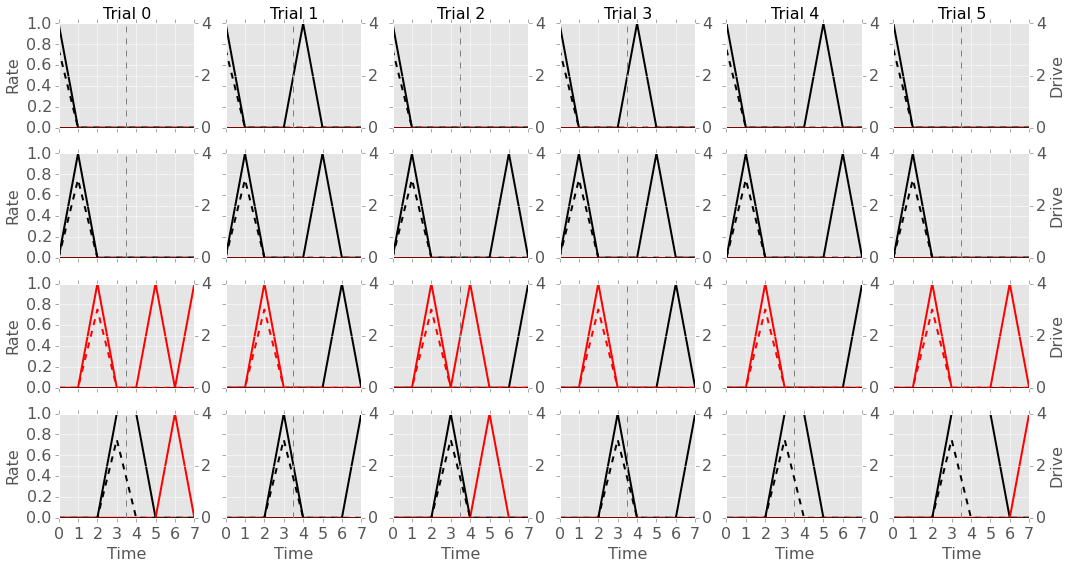

In [12]:
softmax_chains_replay.replay(CONFIG)

Here I have presented the external drive sequence (black-0, black-1, red-2, black-3). Because of this, we see that after the drive is turned off, it is mostly the black chain that activates spontaneously. Interestingly when this occurs, (black-2) activates after (black-1), even though (black-2) was not activated originally by the external drive. We can interpret this as a sort of pattern completion: after the drive is turned off, the pattern that will most probably activate is the *prior* pattern most similar to the external drive sequence, namely some subsequence of (black-0, black-1, black-2, black-3).

Occasionally we also see the second half of the red chain activate spontaneously. However, we never see the exact sequence (black-0, black-1, red-2, black-3) we presented activate spontaneously.

Below, however, we see that when the evoked sequence equally resembles two prior sequences, the subsequently recruited spontaneous sequence has an equal probability of starting from either of the two prior sequences.

In [4]:
CONFIG['DRIVE_BY_COORDINATE'] = [
    [((0, chain_pos), 3) if chain_pos < 2 else ((1, chain_pos), 3) for chain_pos in range(4)]
    + 4 * [((0, 0), 0)]
    for _ in range(6)
]

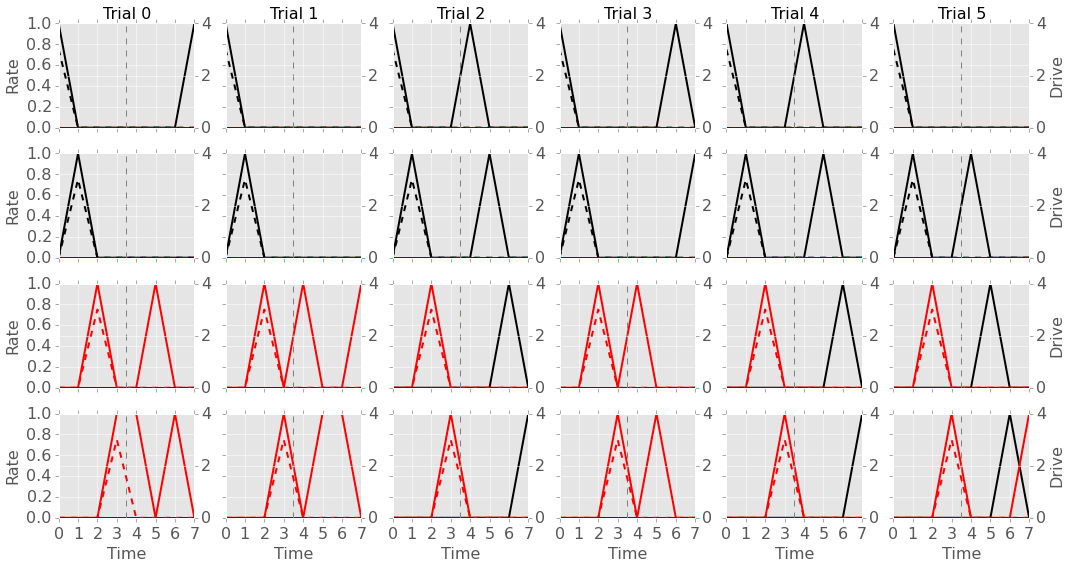

In [18]:
softmax_chains_replay.replay(CONFIG)

Here the sequence (black-0, black-1, red-2, red-3) was induced by external drive. When the drive is turned off, there is an equal probability that the black and red chains will be activated. 

### Replay of prior patterns elicited by weak drive
When the drive is weak and the evoked activity pattern does not perfectly follow the drive, the replayed activity will reflect not the drive explicitly, but only the activity pattern it elicited.

In [5]:
CONFIG['DRIVE_BY_COORDINATE'] = [
    [((chain_idx, chain_pos), 1) if chain_pos != 2 else (((chain_idx + 1)%6, chain_pos), 1) for chain_pos in range(4)]
    + 4 * [((0, 0), 0)]
    for chain_idx in range(6)
]

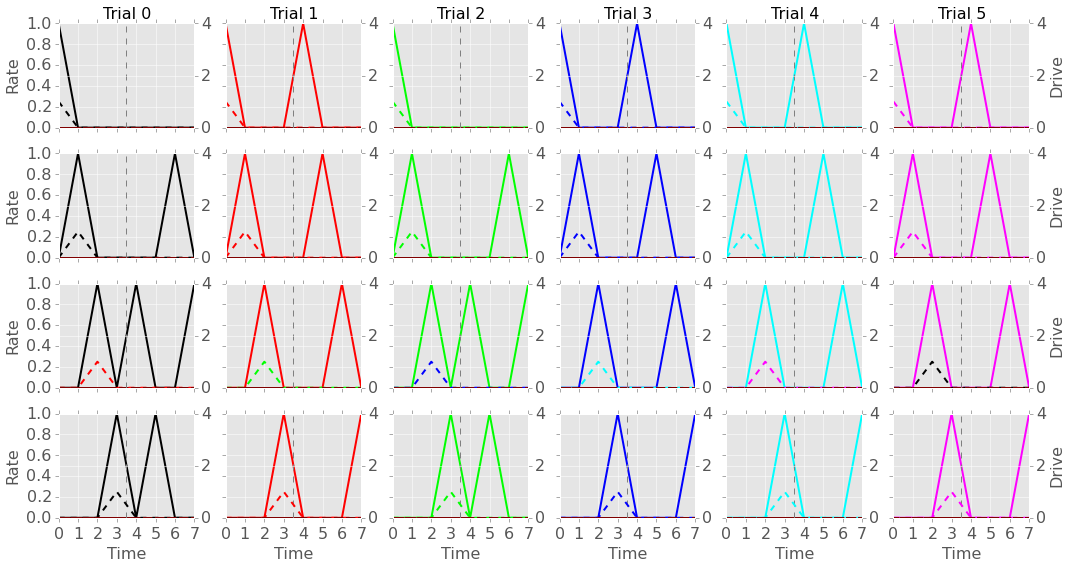

In [20]:
softmax_chains_replay.replay(CONFIG)

Here the activity pattern does not completely match the drive that elicited it. The activity pattern that occurred is then that which gets replayed.

# Weak connections and their role in the replay of novel sequences
I now consider how a network with additional connections weakly linking the chains can allow the network to remember and replay a certain subset of *novel* sequences. To do this we consider a network augmented as in the diagram below.
<img src="files/softmax_chains_weak_links.png" width="500">
Here, the second node of each chain connects weakly to the third node of the chain immediately below it. This generalizes the previous network to the more biological situation of the attractors in a network not being completely isolated from one another. Whereas strong connections have weight $w_{strong}$, weak connections have weight $w_{weak}$.

### Weak connections do not need to affect prior sequence distribution
Here we show that a connection can be weak enough that it does not interfere with the spontaneous activation of prior patterns, but strong enough that novel patterns involving the two sequences it links can emerge in subsequent spontaneous activity with a significant probability.

In [11]:
CONFIG['WEAK_CXN_IDXS'] = (1, 2)
CONFIG['WEAK_CXN_WEIGHT'] = 1
CONFIG['DRIVE_BY_COORDINATE'] = [
    [((chain_idx, 0), 1)] + 3 * [((0, 0), 0)]
    for chain_idx in range(6)
]

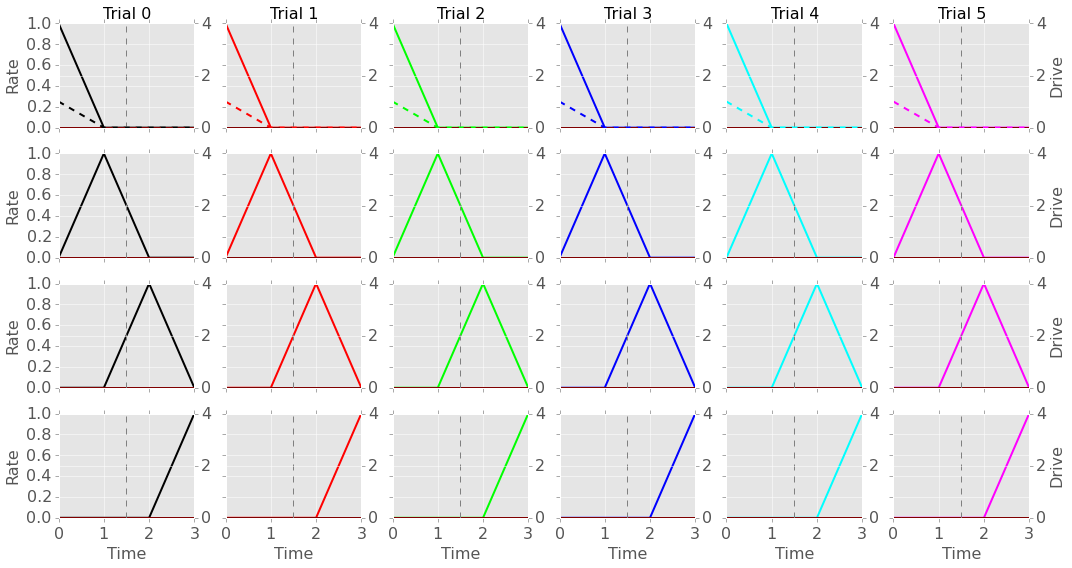

In [12]:
softmax_chains_replay.replay_weak_cxns_added(CONFIG)

Here we see that even though weak connections are present, when the first node in each primary chain is stimulated the rest of the primary chain is activated.

### Weak connections can, however, affect replay
Next I show that because the network contains weak links between chains, history-dependent excitability allows novel sequences to replayed if they comprise ordered segments of the primary chains. For example, below I drive the network with sequence (black-0, black-1, red-2, red-3). Even though this sequence would never arise spontaneously, after it has been elicited once by external drive, the next time (black-1) is activated, (black-1)'s weak input to (red-2) combined with (red-2)'s increased excitability brings (red-2)'s total effective input up to a value such that it can compete with (black-2).

In [13]:
CONFIG['WEAK_CXN_IDXS'] = (1, 2)
CONFIG['WEAK_CXN_WEIGHT'] = 1
CONFIG['DRIVE_BY_COORDINATE'] = [
    [((0, chain_pos), 3) if chain_pos < 2 else ((1, chain_pos), 3) for chain_pos in range(4)] + 
    [((0, 0), 0), ((0, 0), 0), ((0, 0), 0), ((0, 0), 0)]
    for _ in range(6)
]

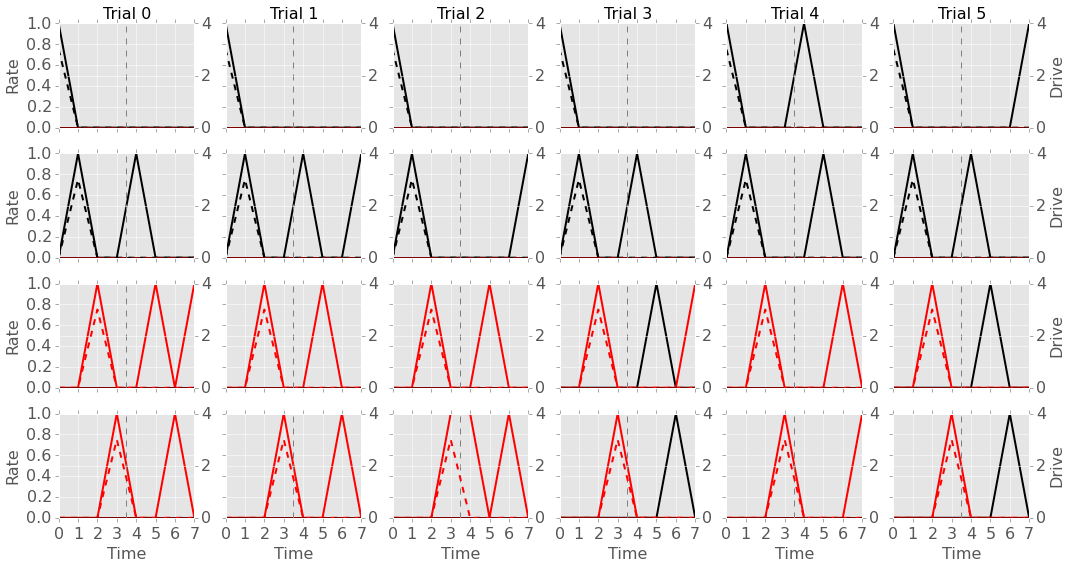

In [14]:
softmax_chains_replay.replay_weak_cxns_added(CONFIG)

Here we see that even though the (black-1, red-2) sequence never arose spontaneously, the weak connections allow it to arise via history-depenendent excitability after it has already occurred in the recent past. Importantly, no synaptic modifications are required for this to occur.

### Summary of part 2
In part 2, I've used a simple network model to show how history-dependent excitability, that is, the tendency of a recently activated node to persist in a state in which it effectively receives additional sustained input, can lead to stimulus-dependent replay of activation sequences. Importantly, the sequences that get replayed with higher probability are the prior patterns most similar to the sequence elicited by the external drive.

History-dependent excitability also allows the network to learn novel sequences if the network contains weak connections betweeen its prior sequences. This is because when a node is receiving effective input via history-dependent excitability, the effect of the weak input suddenly becomes important (since it is effectively multiplied with the history-dependent input via the exponential). Thus, the novel sequence can compete with the prior sequence.

In short, this demonstrates the utility of short-term excitability changes for replay, which is likely a crucial feature of one-shot learning. Biophysically history-dependent excitability could be manifested by short-term changes in intrinsic cell properties or by persistent activity that effectively acts as an input to the recently activated node.

### [Go to part 3](softmax_chains_planning_and_learning.ipynb)